In [1]:
from QuantLib import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
depo_maturities = [Period(6,Months), Period(12, Months)]
depo_rates = [5.25, 5.5]
# Bond rates
bond_maturities = [Period(6*i, Months) for i in range(3,21)]
bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15, 7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]
maturities = depo_maturities+bond_maturities
rates = depo_rates+bond_rates
pd.DataFrame(list(zip(maturities, rates)) , columns=["Maturities","Curve"], index=['']*len(rates))
#print_curve(depo_maturities+bond_maturities, depo_rates+bond_rates)


,Maturities,Curve
,6M,5.25
,1Y,5.50
,1Y6M,5.75
,2Y,6.00
,2Y6M,6.25
,3Y,6.50
,3Y6M,6.75
,4Y,6.80
,4Y6M,7.00
,5Y,7.10


In [3]:
calc_date = Date(15, 1, 2015)
Settings.instance().evaluationDate = calc_date
calendar = UnitedStates()
bussiness_convention = Unadjusted
day_count = Thirty360()
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = Period(Semiannual)
settlement_days = 0

In [4]:
depo_helpers = [DepositRateHelper(QuoteHandle(SimpleQuote(r/100.0)),
                                          m,
                                          settlement_days,
                                          calendar,
                                          bussiness_convention,
                                          end_of_month,
                                          day_count )
                for r, m in zip(depo_rates, depo_maturities)]

In [5]:
bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
            termination_date = calc_date + m
            schedule = Schedule(calc_date,
                                termination_date,
                                coupon_frequency,
                                calendar,
                                bussiness_convention,
                                bussiness_convention,
                                DateGeneration.Backward,
                                end_of_month)
            bond_helper = FixedRateBondHelper(QuoteHandle(SimpleQuote(face_amount)),
                                              settlement_days,
                                              face_amount,
                                              schedule,
                                              [r/100.0],
                                              day_count,
                                              bussiness_convention,
                                              )
            bond_helpers.append(bond_helper)

In [6]:
rate_helpers = depo_helpers + bond_helpers

In [7]:
def get_spot_rates( yieldcurve, day_count,
                calendar=UnitedStates(), months=121):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    for month in range(0, months):
                yrs = month/12.0
                d = calendar.advance(ref_date, Period(month, Months))
                compounding = Compounded
                freq = Semiannual
                zero_rate = yieldcurve.zeroRate(yrs, compounding, freq).rate()
                tenors.append(yrs)
#                eq_rate = zero_rate.equivalentRate(
#                    day_count,compounding,freq,calc_date,d).rate()
                spots.append(100*zero_rate)
    return pd.DataFrame(list(zip(tenors, spots)), columns=["Maturities","Curve"],
                      index=['']*len(tenors))

In [8]:
yc_logcubicdiscount = PiecewiseLogCubicDiscount(calc_date,
                                            rate_helpers,
                                            day_count)

In [9]:
splcd = get_spot_rates(yc_logcubicdiscount, day_count)
splcd.iloc[0:121, 0:2]

,Maturities,Curve
,0.000000,5.210205
,0.083333,5.211311
,0.166667,5.214626
,0.250000,5.220153
,0.333333,5.227891
,0.416667,5.237840
,0.500000,5.250000
,0.583333,5.264824
,0.666667,5.284119
,0.750000,5.309243


In [10]:
yc_linearzero = PiecewiseLinearZero(
                 calc_date,rate_helpers,day_count)
yc_cubiczero = PiecewiseCubicZero(
                 calc_date,rate_helpers,day_count)
splz = get_spot_rates(yc_linearzero, day_count)
spcz = get_spot_rates(yc_cubiczero, day_count)
splz.iloc[0:121, 0:2]

,Maturities,Curve
,0.000000,5.250000
,0.083333,5.250000
,0.166667,5.250000
,0.250000,5.250000
,0.333333,5.250000
,0.416667,5.250000
,0.500000,5.250000
,0.583333,5.279387
,0.666667,5.308778
,0.750000,5.338174


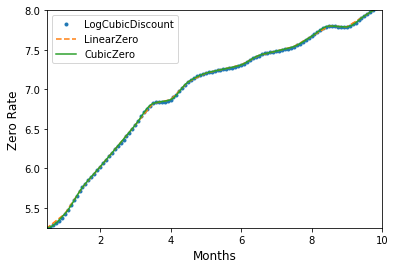

In [11]:
plt.plot(splcd["Maturities"],splcd["Curve"], '.',
                  label="LogCubicDiscount")
plt.plot(splz["Maturities"],splz["Curve"],'--',
                  label="LinearZero")
plt.plot(spcz["Maturities"],spcz["Curve"],
                  label="CubicZero")
plt.xlabel("Months", size=12)
plt.ylabel("Zero Rate", size=12)
plt.xlim(0.5,10)
plt.ylim([5.25,8])
plt.legend()

In [12]:
yc_flatforward = PiecewiseFlatForward(
                 calc_date,rate_helpers,day_count)
spff = get_spot_rates(yc_flatforward, day_count)
spff.iloc[0:121, 0:2]

,Maturities,Curve
,0.000000,5.250000
,0.083333,5.250000
,0.166667,5.250000
,0.250000,5.250000
,0.333333,5.250000
,0.416667,5.250000
,0.500000,5.250000
,0.583333,5.300380
,0.666667,5.338174
,0.750000,5.367574


In [15]:
yc_flatforward = PiecewiseFlatForward(
                 calc_date,rate_helpers,day_count)

In [16]:
nodes = list(yc_flatforward.nodes())

In [18]:
nodes[:121]

[(Date(15,1,2015), 0.05182276356900196),
 (Date(15,7,2015), 0.05182276356900196),
 (Date(15,1,2016), 0.0552587702870576),
 (Date(15,7,2016), 0.06331073639569226),
 (Date(15,1,2017), 0.06686569101025051),
 (Date(15,7,2017), 0.0720669631793604),
 (Date(15,1,2018), 0.07739216782950552),
 (Date(15,7,2018), 0.08286267685022801),
 (Date(15,1,2019), 0.07079403738151895),
 (Date(15,7,2019), 0.0871342135279063),
 (Date(15,1,2020), 0.0803267090704224),
 (Date(15,7,2020), 0.07624137357871995),
 (Date(15,1,2021), 0.07745878288649424),
 (Date(15,7,2021), 0.08671211488510247),
 (Date(15,1,2022), 0.08050861376716553),
 (Date(15,7,2022), 0.08183584410230318),
 (Date(15,1,2023), 0.09379567350454962),
 (Date(15,7,2023), 0.09674366666028335),
 (Date(15,1,2024), 0.07459156948751998),
 (Date(15,7,2024), 0.10176402591640026),
 (Date(15,1,2025), 0.10511843764697335)]

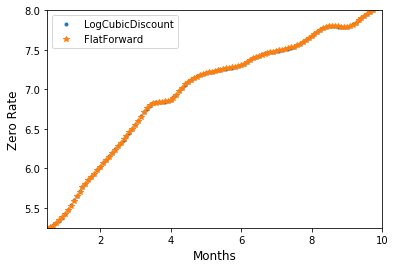

In [14]:
plt.plot(splcd["Maturities"],splcd["Curve"], '.',
                  label="LogCubicDiscount")
#plt.plot(splz["Maturities"],splz["Curve"],'--',
 #                 label="LinearZero")
#plt.plot(spcz["Maturities"],spcz["Curve"],
 #                 label="CubicZero")
plt.plot(spff["Maturities"],spcz["Curve"], '*',
                  label="FlatForward")
plt.xlabel("Months", size=12)
plt.ylabel("Zero Rate", size=12)
plt.xlim(0.5,10)
plt.ylim([5.25,8])
plt.legend()